In [ ]:
# for Google Colab
# !git clone https://github.com/pavelshapka/Q_func_AM.git
# !pip3 install -r /content/Q_func_AM/requirements.txt
# import os
# os.chdir("/content/Q_func_AM")

In [1]:
# for virtual machine
!pip3 install -r requirements.txt

In [26]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.95' 

import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

from classification.default_loader import get_base_dataloaders, CIFAR10_MEANS, CIFAR10_STD
# from sas_stack.sars_dataloader import get_sars_dataloaders
from sa_stack import get_sar_dataloaders, TrainerModule, RegressionInceptionNetV1
# from td_sa_stack import get_sarsa_opt_dataloaders, TrainerModule, RegressionInceptionNetV1

import jax
import matplotlib.pyplot as plt
from flax import linen as nn
from matplotlib.gridspec import GridSpec

import numpy as np

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
jax.devices()

[CudaDevice(id=0)]

In [3]:
bs = 512

train_loader, val_loader = get_sar_dataloaders(batch_size=bs,
                                               reward=10,
                                               gamma=0.9,
                                               min_num_steps=3,
                                               max_num_steps=23,
                                               with_reversed_transitions=True)

In [4]:
train_iter = iter(train_loader)
images, rewards = next(train_iter)

val_iter = iter(val_loader)
val_images, val_rewards = next(val_iter)

2025-04-28 20:12:27.941587: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [5]:
states = val_images[..., :3]
actions = val_images[..., 3:6]
# states_hat = val_images[..., 6:9]

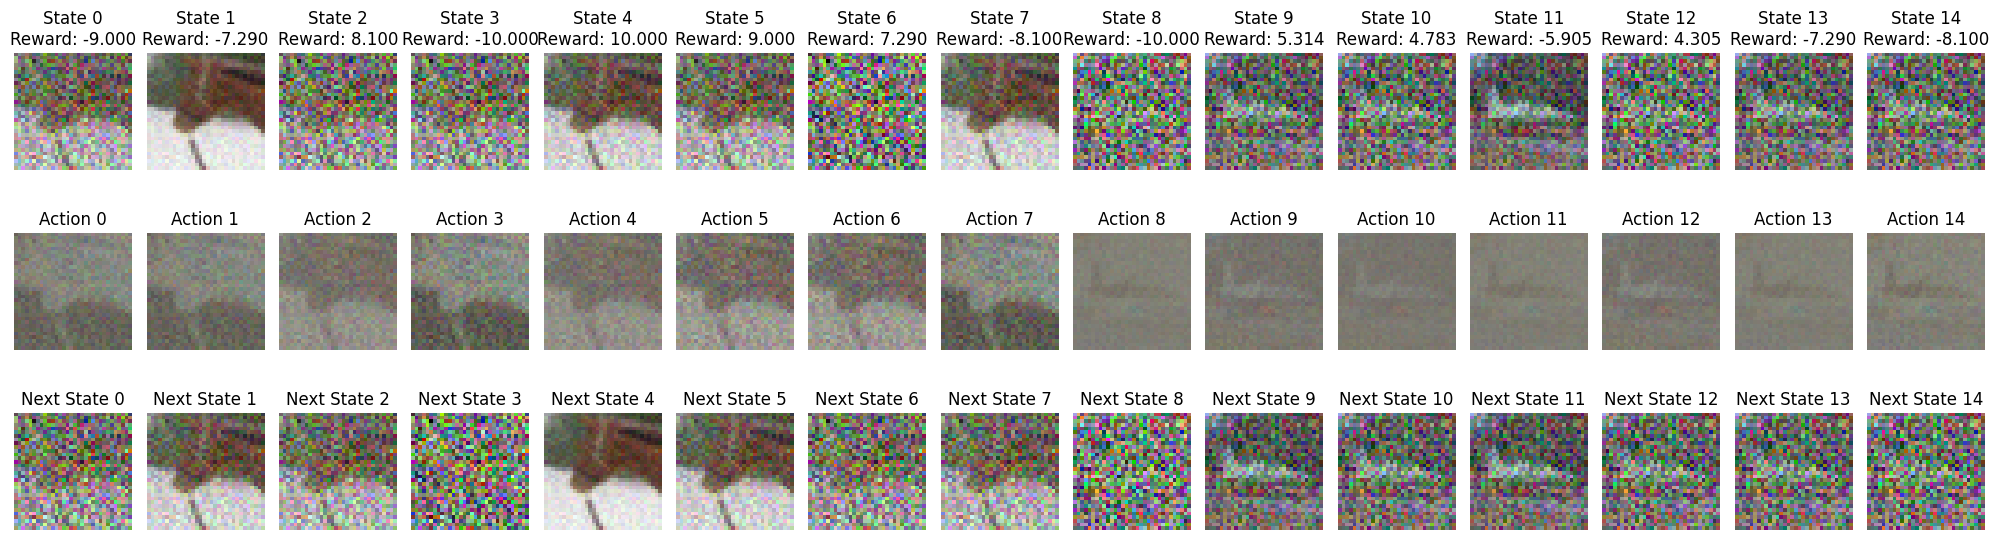

In [6]:
def plot_trajectory(s, a, num_steps=15):
    plt.figure(figsize=(20, 6))

    for i in range(num_steps):
        # State
        plt.subplot(3, num_steps, i+1)
        plt.imshow((s[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))  # Денормализация
        plt.title(f"State {i}\nReward: {val_rewards[i][0]:.3f}")
        plt.axis('off')

        # Action (визуализируем как разницу)
        plt.subplot(3, num_steps, num_steps+i+1)
        plt.imshow((a[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
        plt.title(f"Action {i}")
        plt.axis('off')

        # Next State
        plt.subplot(3, num_steps, 2*num_steps+i+1)
        plt.imshow(((s[i].numpy() + a[i].numpy()) * CIFAR10_STD + CIFAR10_MEANS))
        plt.title(f"Next State {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Визуализируем первую траекторию в батче
plot_trajectory(states, actions)

In [15]:
def train_sa_regressor(*args, num_epochs=200, start_from=0, train=True, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if trainer.checkpoint_exists():
        start_from = trainer.load_model()

    if train:
        print(f"current_epoch = {start_from}")
        trainer.train_model(train_loader,
                            val_loader,
                            rng=jax.random.PRNGKey(42),
                            num_epochs=num_epochs,
                            start_from=start_from)
    # Test trained model
    val_loss = trainer.eval_model(val_loader)
    return trainer, {'val': val_loss}

In [ ]:
googlenet_trainer, googlenet_results = train_sa_regressor(model_class=RegressionInceptionNetV1,
                                                          model_name="RegressionInceptionNetV1",
                                                          model_hparams={"activation": nn.relu},
                                                          batch_size=bs,
                                                          optimizer_name="adamw",
                                                          optimizer_hparams={"lr": 1e-4,
                                                                             "weight_decay": 1e-5},
                                                          exmp_imgs=jax.device_put(next(iter(train_loader))[0]._numpy()),
                                                          num_epochs=500,
                                                          mode="reversed",
                                                          train=True)

2025-04-28 08:20:16.240945: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


current_epoch = 0


  0%|          | 0/500 [00:00<?, ?it/s]2025-04-28 08:29:32.763596: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-28 08:30:02.348267: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  6%|▌         | 30/500 [4:23:15<66:35:58, 510.12s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7e744f846680>>
Traceback (most recent call last):
  File "/home/pvshapka/Q_func_AM/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [8]:
def load_model(*args, **kwargs):
	trainer = TrainerModule(*args, **kwargs)
	trainer.init_optimizer(num_epochs=500, num_steps_per_epoch=1_000)
	if trainer.checkpoint_exists():
		_ = trainer.load_model()
		
	return trainer

trainer = load_model(model_class=RegressionInceptionNetV1,
					 model_name="RegressionInceptionNetV1",
					 model_hparams={"activation": nn.relu},
					 batch_size=bs,
					 optimizer_name="adamw",
					 optimizer_hparams={"lr": 1e-4,
										"weight_decay": 1e-5},
					 exmp_imgs=jax.device_put(next(iter(train_loader))[0]._numpy()),
					 mode="reversed")

2025-04-28 20:17:21.133256: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shapka-pa (shapka-pa-moscow-institute-of-physics-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-1170' coro=<Event.wait() running at /usr/lib/python3.10/asyncio/locks.py:214> wait_for=<Future cancelled>>


Loaded model from epoch 30 with step 67399


In [29]:
_, print_loader = get_sar_dataloaders(batch_size=bs,
                                      reward=10,
                                      gamma=0.9,
                                      min_num_steps=3,
                                      max_num_steps=23,
                                      with_reversed_transitions=False,
                                      with_shuffled_transitions=False)

print_iter = iter(print_loader)

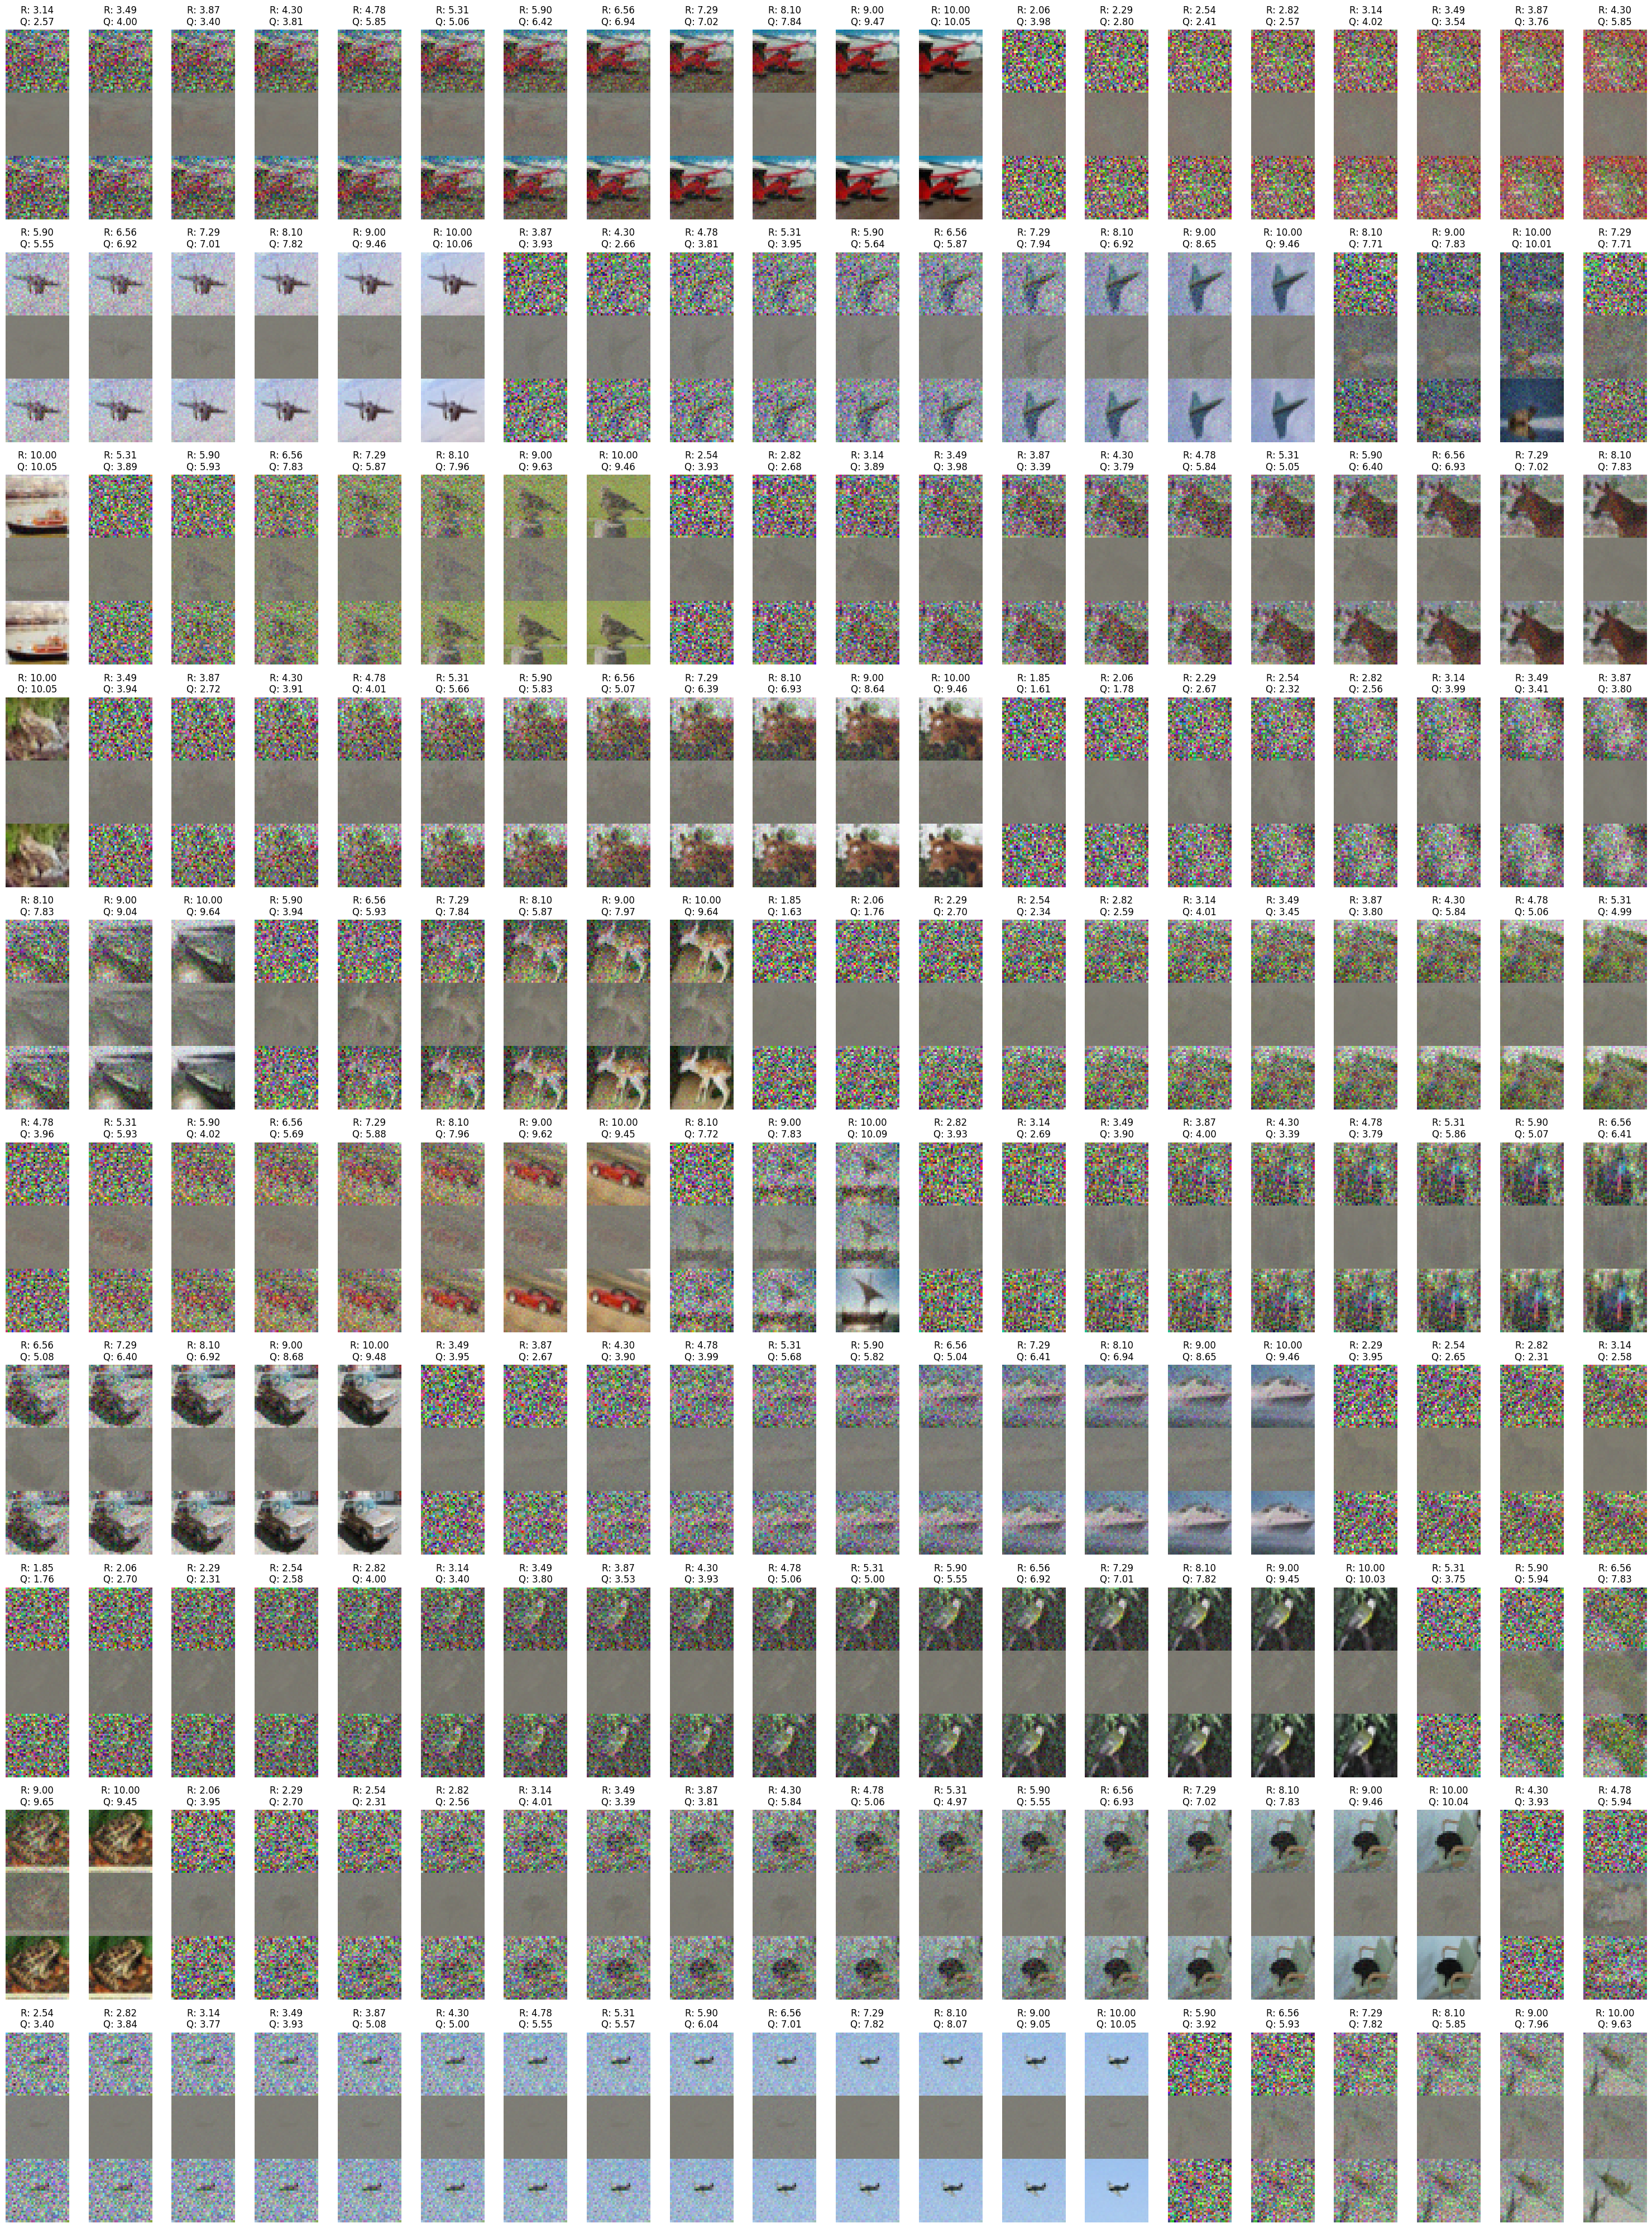

In [45]:
samples_count = 10
wide = 20

plt.figure(figsize=(30, 4 * samples_count))
gs = GridSpec(samples_count, wide)

def extract_one_trajectory(ds_iter):
	sarsa_batch, rewards = next(ds_iter)
	to = 20
	# to = np.argmax(rewards[:, 0] == 10)
	return sarsa_batch[:to+1], rewards[:to+1, 0]


for i in range(samples_count):
	trajectory, rewards = extract_one_trajectory(print_iter)
	traj_length = trajectory.shape[0]

	params, batch_stats = trainer.state.params, trainer.state.batch_stats
	q_values_pred = trainer.model.apply({"params": params, "batch_stats": batch_stats}, trajectory)

	for j in range(min(traj_length, wide)):
		ax = plt.subplot(gs[i, j])
		s = trajectory[j, :, :, :3] * CIFAR10_STD + CIFAR10_MEANS
		a = trajectory[j, :, :, 3:] * CIFAR10_STD + CIFAR10_MEANS
		s_next = (trajectory[j, :, :, :3] + trajectory[j, :, :, 3:]) * CIFAR10_STD + CIFAR10_MEANS
		ax.imshow(np.concatenate([s, a, s_next], axis=0))

		ax.axis('off')
		ax.set_title(f"R: {rewards[j]:.2f}\nQ: {q_values_pred[j, 0]:.2f}")

plt.tight_layout()
plt.show()
		

## Проверим, что модель корректна через обучение классификации на CIFAR-10

In [ ]:
train_loader, val_loader, test_loader = get_base_dataloaders(batch_size=16)

In [ ]:
train_iter = iter(train_loader)
images, _ = next(train_iter)

In [ ]:
NUM_IMAGES = 10

nrows, ncols = 2, 5
fig, axs = plt.subplots(figsize=(20, 10), nrows=nrows, ncols=ncols)

for i in range(NUM_IMAGES):
    img = (images[i]._numpy() * CIFAR10_STD + CIFAR10_MEANS)
    axs[i//ncols, i%ncols].imshow(img)
    axs[i//ncols, i%ncols].axis("off")

plt.show()
plt.close()

In [ ]:
def train_classifier(*args, num_epochs=200, start_from=0, train=True, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if trainer.checkpoint_exists():
        start_from = trainer.load_model()

    if train:
        print(f"current_epoch = {start_from}")
        trainer.train_model(train_loader,
                            val_loader,
                            rng=jax.random.PRNGKey(42),
                            num_epochs=num_epochs,
                            start_from=start_from)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

In [ ]:
googlenet_trainer, googlenet_results = train_classifier(model_class=InceptionNetV1,
                                                        model_name="InceptionNetV1",
                                                        model_hparams={"num_classes": 10,
                                                                       "activation": nn.relu},
                                                        optimizer_name="adamw",
                                                        optimizer_hparams={"lr": 3e-4,
                                                                           "weight_decay": 1e-5},
                                                        exmp_imgs=jax.device_put(next(iter(train_loader))[0]._numpy()),
                                                        num_epochs=10,
                                                        train=True)

In [ ]:
googlenet_results